# Phase estimation with QCNN (N = 8)

Reproducing results from: https://arxiv.org/abs/1906.10155

In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
##############


In [2]:
dev_vqe = qml.device('default.qubit', wires=8)

## States preparation through VQE

<img src="./imgs/ansatz.svg" alt="ansatz" width="1000"/>

In [9]:
###################
## VQE FUNCTIONS ##
###################

def qml_build_H(N, lam, J):
    '''
    Set up Hamiltonian: 
            H = lam*Σsigma^i_z - J*Σsigma^i_x*sigma^{i+1}_ 
    '''
    # Interaction of spins with magnetic field
    H = lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + J*(-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
        
    # Ising Ring
    # H = H + J*(-1)*( qml.PauliX(0) @ qml.PauliX(N-1) )
    
    return H

def vqe_circuit_1(param, N = 8):
    '''
    Build the circuit to find the Groud-State of the 
    Ising-Chain Hamiltonian
    '''
    for spin in range(N):
        qml.RY(param[spin], wires = spin)
        qml.RX(param[N+spin], wires = spin)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
    
    qml.Barrier()
    
    for spin in range(N):
        qml.RY(param[2*N   + spin], wires = spin)
        qml.RX(param[3*N   + spin], wires = spin)
    
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
        
    for spin in range(N):
        qml.RY(param[4*N + spin], wires = spin)
        
def show_params_ising_chain(thetas_arr):
    '''
    thetas_arr: array of the following structure:
                    list( (J_value, angles of the circuit (vqe_ising_chain_circuit) ) )
    '''
    for J in range(len(thetas_arr)):
        plt.title('J = {0}'.format(thetas_arr[J][0])) 

        pm = plt.imshow(np.abs(thetas_arr[J][1]))

        for i in range(np.shape(thetas_arr[J][1])[1]):
            plt.axvline(x=i - .5, color = 'black')

        plt.ylabel(r'$\lambda$')

        plt.colorbar(pm, shrink=0.3, aspect=20)
        plt.tight_layout()
        plt.show()    
        
def train_vqe_ising(step_size, l_steps, n_epochs, N, J, dev, circuit = False, plots = False, first_epochs = False):
    '''
    step_size = Step size of the optimizer
    epochs    = # epochs for each lambda (magnetic field)
    lams      = Array of intensities of magnetic field
    N         = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size = {0} (Step size of the optimizer)'.format(step_size))
    print('epochs    = {0} (# epochs for each lambda)'.format(n_epochs))
    print('N         = {0} (Number of spins of the system)'.format(N))
    
    lams = np.linspace(0,2*J,l_steps)
    
    vqe_e = []
    errs = np.zeros((n_epochs, len(lams)) )
    
    @qml.qnode(dev_vqe)
    def cost_fn(param):
        vqe_circuit_1(param, N)
        # return <psi|H|psi>
        return qml.expval(H)
    
    thetas = np.array(np.random.randn(5*N), requires_grad = True) # Prepare initial state
    
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        
        H = qml_build_H(N, 0, 0)        
        drawer = qml.draw(cost_fn)
        print(drawer(thetas))
    
    thetas_arr = []
    ys = [] # Labels of the phase
    for i, l in enumerate(tqdm(lams)):
        opt = qml.AdamOptimizer(stepsize=step_size)
        H = qml_build_H(N, float(l), J)
        
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = np.min(qml.eigvals(H))
        
        epochs = first_epochs if i == 0 else n_epochs
        
        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            if i != 0:
                if epoch < n_epochs:
                    errs[epoch-1, i] = (prev_energy - GS_H)**2
            
        vqe_e.append(cost_fn(thetas))
        thetas_arr.append(thetas)
        ys.append(0) if l <= J else ys.append(1)
        
    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(10,10))

        true_e = []
        for l in lams:
            H = qml_build_H(N, float(l), J)
            true_e.append(np.min(qml.eigvals(H)) )
            
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()

        ax[1].plot(range(epochs), np.mean(errs, axis=1), '.', color='orange', ms = 7 )
        ax[1].plot(range(epochs), np.mean(errs, axis=1), color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        ax[2].legend()
        
        plt.tight_layout()
        plt.show()
        
         
        
    return vqe_e, errs, thetas_arr, ys      

***Parameters:***

step_size = 0.25 (Step size of the optimizer)
epochs    = 50 (# epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(0.99)───RX(0.69)──╭C────────────────────||──RY(0.08)───RX(0.99)──╭C──RY(0.09)───────────
1: ──RY(0.31)───RX(1.07)──╰X─╭C─────────────────||──RY(0.43)───RX(-0.40)─╰X─╭C─────────RY(-0.33)
2: ──RY(-0.00)──RX(1.08)─────╰X─╭C──────────────||──RY(-2.70)──RX(0.51)─────╰X────────╭C────────
3: ──RY(-0.13)──RX(0.40)────────╰X─╭C───────────||──RY(0.23)───RX(-2.19)──────────────╰X────────
4: ──RY(0.25)───RX(-0.91)──────────╰X─╭C────────||──RY(-0.53)──RX(1.05)─────────────────────────
5: ──RY(0.35)───RX(1.10)──────────────╰X─╭C─────||──RY(0.67)───RX(1.90)─────────────────────────
6: ──RY(1.60)───RX(0.18)─────────────────╰X─╭C──||──RY(-1.03)──RX(1.60)─────────────────────────
7: ──RY(0.84)───RX(-0.71)───────────────────╰X──||──RY(-0.70)──RX(1.10)─────────────────────────

──────────────────────────────────────────────────────┤ ╭<𝓗>
──────────────────────────────────────────────────────┤ ├<𝓗>
───RY(-0.44)──────────────────────────────────────────┤ ├<𝓗>
──╭C──────────RY(0.12)──────────────────

  0%|          | 0/100 [00:00<?, ?it/s]

/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/pennylane/ops/functions/eigvals.py:104: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


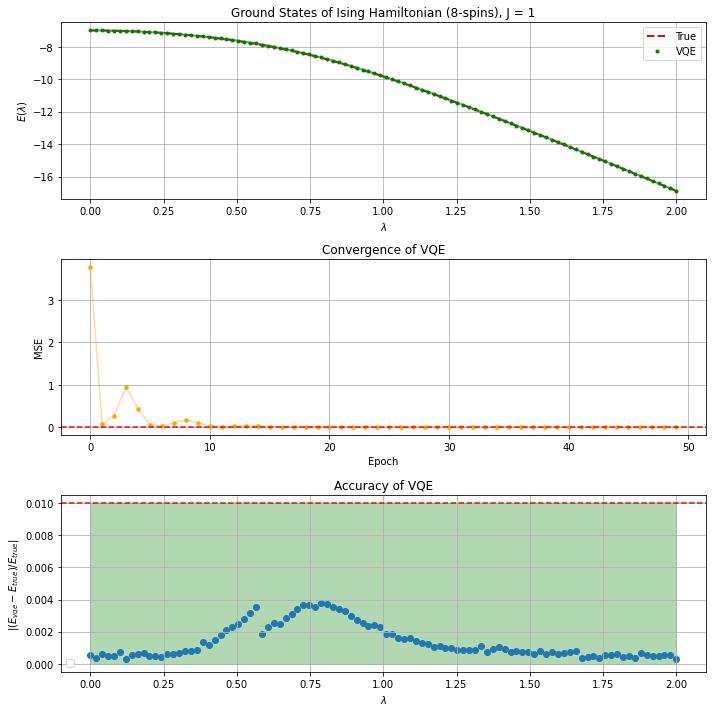

[[-1.000e-02 -9.880e-01  1.100e-02 ...  0.000e+00 -1.000e-02  8.000e-03]
 [ 9.600e-02 -1.042e+00 -1.200e-02 ...  1.000e-03 -3.000e-03  3.000e-02]
 [ 1.700e-02 -1.591e+00 -3.000e-03 ...  7.000e-03  1.900e-02  5.900e-02]
 ...
 [-1.589e+00 -1.313e+00 -1.553e+00 ...  1.560e+00  1.544e+00  1.553e+00]
 [-1.563e+00 -1.318e+00 -1.555e+00 ...  1.597e+00  1.577e+00  1.568e+00]
 [-1.544e+00 -1.305e+00 -1.616e+00 ...  1.555e+00  1.572e+00  1.577e+00]]


/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


In [4]:
for it_j, J in enumerate([1]):
    vqe_e, errs, thetas, ys = train_vqe_ising(step_size = 0.25, l_steps = 100, n_epochs = 50, N = 8, J = J,
                                              dev = dev_vqe, circuit = True, plots = True, first_epochs = 500)
    if it_j == 0:
        vqe_data_x = thetas 
        vqe_data_y = ys
    else:
        vqe_data_x = np.concatenate((vqe_data_x, thetas))
        vqe_data_y = np.concatenate((vqe_data_y, ys))
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_circuit_params.job')

print( np.round(np.asarray(thetas),3))

## Phase estimation through QCNN

Convolution layer:

<img src="./imgs/conv.svg" alt="conv" width="300"/>

Pooling block:

<img src="./imgs/pool.svg" alt="pool" width="500"/>

In [5]:
dev_qcnn = qml.device('default.qubit.jax', wires=8)

In [6]:
# Load data and separate in training and test set
data_full = joblib.load('./vqe_circuit_params.job')

# Count the number of samples
samples_full = len(data_full)

data = data_full[:100]
samples = len(data)
print('Size of Data Set: {0}'.format(samples))

train_index = np.sort(np.random.choice(np.arange(samples), size=int(0.8*samples), replace=False ))
test_index = []
for i in range(len(data)):
    if not i in train_index:
        test_index.append(i)

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)

print('______________________________')
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))


Size of Data Set: 100
______________________________
Size of Training Set: 80
Size of Test Set    : 20


In [28]:
####################
## QCNN FUNCTIONS ##
####################
    
@qml.qnode(dev_qcnn, interface="jax", diff_method="best")     
def qcnn_8(params_vqe,params):
    '''
    QCNN circuit:
    VQE STATE PREPARATION + CONVOLUTION + POOLING
    '''
    N = 8
    vqe_circuit_1(params_vqe, N)
    qml.Barrier()
    
    k = 0
    
    # Prepare wires for convolution:
    for wire in range(N):
        qml.RX(params[k], wires = wire)
        k = k + 1
        qml.RY(params[k], wires = wire)
        k = k + 1
        
    # Establish entanglement (1/2):
    for wire, wire_next in zip(range(0,N,2), range(1,N,2)):
        qml.CNOT(wires=[wire, wire_next])
        qml.RX(params[k], wires = wire)
        k = k + 1
        
    qml.Barrier()
    # Establish entanglement (2/2):
    for wire, wire_next in zip(range(1,N,2), range(2,N,2)):
        qml.CNOT(wires=[wire, wire_next])
        qml.RX(params[k], wires = wire)
        k = k + 1
        
    qml.RX(params[k], wires = N-1)
    k = k + 1
    
    qml.Barrier()
        
    # Pooling 8-> 4
    for wire_meas, wire_next in zip(range(0,N,2), range(1,N,2)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RX)(params[k], wires=wire_next)
        k = k + 1
    
    qml.Barrier()
    
    
    # Second convolution:
    qml.RX(params[k], wires = 1)
    qml.RY(params[k+1], wires = 1)
    k = k + 2
    
    qml.RX(params[k], wires = 3)
    qml.RY(params[k+1], wires = 3)
    k = k + 2
    
    qml.RX(params[k], wires = 5)
    qml.RY(params[k+1], wires = 5)
    k = k + 2
    
    qml.RX(params[k], wires = 7)
    qml.RY(params[k+1], wires = 7)
    k = k + 2
    
    qml.CNOT(wires=[1, 3])
    qml.CNOT(wires=[5, 7])
    qml.CNOT(wires=[3, 5])
    qml.RX(params[k], wires = 1)
    qml.RX(params[k+1], wires = 3)
    qml.RX(params[k+2], wires = 5)
    qml.RX(params[k+3], wires = 7)
    
    k = k + 4
    
    # Second pooling 4->2
    for wire_meas, wire_next in zip(range(1,N,4), range(3,N,4)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RZ)(params[k], wires=wire_next)
        k = k + 1
        
    qml.Barrier()
    
    qml.RX(params[k], wires = 3)
    k = k + 1
    qml.RY(params[k], wires = 3)
    k = k + 1
    qml.RX(params[k], wires = 7)
    k = k + 1
    qml.RY(params[k], wires = 7)
    k = k + 1
    
    qml.CNOT(wires=[3, 7])
    qml.RX(params[k], wires = 3)
    qml.RX(params[k+1], wires = 7)
    k = k + 2
    
    # Third pooling 2->1
    for wire_meas, wire_next in zip(range(3,N,8), range(7,N,4)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RZ)(params[k], wires=wire_next)
        k = k + 1
    
    qml.RY(params[k], wires = 7)
    
    return qml.probs(wires=7)

# Estimation functions for QCNN

def cross_entropy(labels, predictions):
    '''
    f = - Σ [(Yi*log(Pi) + (1 - Yi)*log(1 - Pi) )]  for i in TrainingSet
    '''
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l])
        loss = loss + c_entropy

    return -1 * loss

def cost_fn(params, X, Y):
    fn = lambda v: qcnn_8(v, params)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)

    predictions = vcircuit(X)
    #predictions = [qcnn_8(x, params) for x in X]
    loss = cross_entropy(Y, predictions)
    
    return loss

def compute_cost_batch(X, Y, params):
    '''
    Accuracy = (corretly predicted labels)/(total # of labels) * 100 ( %100) 
    '''
    data_len = len(X)
    
    if data_len == 0:
        return 0
    
    circuit = lambda v: cost_fn(v, X, Y)
    
    return circuit(params)

def compute_cost(X, Y, params, batch_size):
    n_batches = jnp.shape(X)[0]//batch_size
    
    cost = 0
    for batch in range(n_batches+1):
        start_batch = batch*(batch_size)
        end_batch = min( (batch+1)*(batch_size), jnp.shape(X)[0] )
        
        X_batch, Y_batch = jnp.array(X[start_batch:end_batch]), jnp.array(Y[start_batch:end_batch])
        
        cost = cost + compute_cost_batch(X_batch, Y_batch, params)
        
    return cost
        
def compute_accuracy_batch(X, Y, params):
    '''
    Accuracy = (corretly predicted labels)/(total # of labels) * 100 ( %100) 
    '''
    data_len = len(X)
    
    if data_len == 0:
        return 0
    
    fn = lambda v: qcnn_8(v, params)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)
    
    predictions = vcircuit(X)
    #print(jnp.argmax(predictions, axis=1)== Y)
    
    return (np.sum(jnp.argmax(predictions, axis=1) == jnp.asarray(Y)) )

def compute_accuracy(X, Y, params, batch_size):
    n_batches = jnp.shape(X)[0]//batch_size
    
    correctly_classified = 0
    for batch in range(n_batches+1):
        start_batch = batch*(batch_size)
        end_batch = min( (batch+1)*(batch_size), jnp.shape(X)[0] )
        
        X_batch, Y_batch = jnp.array(X[start_batch:end_batch]), jnp.array(Y[start_batch:end_batch])
        
        correctly_classified += compute_accuracy_batch(X_batch, Y_batch, params)
    
    return 100*correctly_classified/jnp.shape(X)[0]

# Training function
def qcnn_training(X_train, Y_train, X_test = [], Y_test = [], steps = 100, lr0 = 0.001, N = 8, plot = True, batch_size = 8):
    # Initialize parameters randomly
    params = jnp.array( np.random.randn(57) )
    
    loss_history = []
    accuracy_history = []
    #loss_history_test = []
    accuracy_history_test = []
    
    progress = tqdm(range(steps))
    
    n_batches      = jnp.shape(X_train)[0]//batch_size
    n_batches_test = jnp.shape(X_test)[0]//batch_size
    
    lr = lr0
    for epoch in progress:
        lr = lr0*(np.exp(-0.01*epoch))
        
        # Compute current loss and update parameters
        for batch in range(n_batches+1):
            params_batch = copy.copy(params)
            
            start_batch = (batch)*(batch_size)
            end_batch = min( (batch+1)*(batch_size), jnp.shape(X_train)[0] )
            
            if start_batch == end_batch:
                break
                
            X_batch, Y_batch = jnp.array(X_train[start_batch:end_batch]), jnp.array(Y_train[start_batch:end_batch])

            circuit = lambda v: cost_fn(v, X_batch, Y_batch)
            grad_circuit = jax.grad(circuit)
            params -= lr*grad_circuit(params)
        
        if epoch % 10 == 0:
            loss_history.append(compute_cost(X_train, Y_train, params, 16) )
            accuracy_history.append( compute_accuracy(X_train, Y_train, params, 16) )
            
            if len(X_test) > 0:
                accuracy_history_test.append(compute_accuracy(X_test, Y_test, params, 16) )
        
        # Set description to current loss
        progress.set_description('Cost: {0} | Accuracy: {1}'.format(np.round(loss_history[-1],3), accuracy_history[-1]) )
        
    print('Accuracy on Training Set: {0}'.format(compute_accuracy(X_train, Y_train, params, batch_size) ) )

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(loss_history))*10, np.asarray(loss_history), label = 'Training Loss')
       #if len(X_test) > 0:
            #plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(len(accuracy_history))*10, accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(len(accuracy_history))*10, accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return loss_history, accuracy_history, params

In [29]:
drawer = qml.draw(qcnn_8)
print(drawer([0]*100,[0]*57))

0: ──RY(0.00)──RX(0.00)─╭C────────────────────||──RY(0.00)──RX(0.00)─╭C──RY(0.00)──────────
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────────────────||──RY(0.00)──RX(0.00)─╰X─╭C─────────RY(0.00)
2: ──RY(0.00)──RX(0.00)────╰X─╭C──────────────||──RY(0.00)──RX(0.00)────╰X────────╭C───────
3: ──RY(0.00)──RX(0.00)───────╰X─╭C───────────||──RY(0.00)──RX(0.00)──────────────╰X───────
4: ──RY(0.00)──RX(0.00)──────────╰X─╭C────────||──RY(0.00)──RX(0.00)───────────────────────
5: ──RY(0.00)──RX(0.00)─────────────╰X─╭C─────||──RY(0.00)──RX(0.00)───────────────────────
6: ──RY(0.00)──RX(0.00)────────────────╰X─╭C──||──RY(0.00)──RX(0.00)───────────────────────
7: ──RY(0.00)──RX(0.00)───────────────────╰X──||──RY(0.00)──RX(0.00)───────────────────────

─────────────────────────────────────────────────────||──RX(0.00)──RY(0.00)─╭C──RX(0.00)──||
─────────────────────────────────────────────────────||──RX(0.00)──RY(0.00)─╰X────────────||
───RY(0.00)──────────────────────────────────────────||──RX(0.00)──RY(0.00)─╭

  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy on Training Set: 91.25


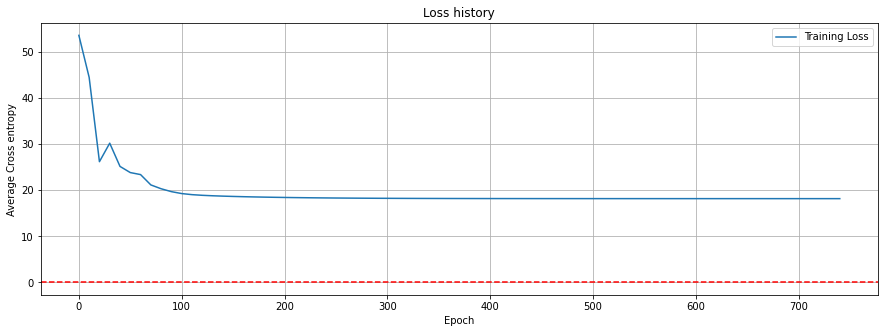

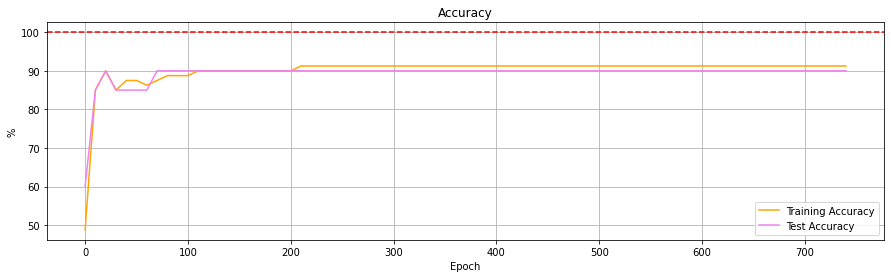

In [30]:
loss_history, accuracy_history, params = qcnn_training(X_train, Y_train, X_test, Y_test, lr0 = 2e-1, steps = 750, batch_size = 16)


In [31]:
predictions_train = []
predictions_test  = []

colors_train = []
colors_test  = []

for i in range(len(data)):
    prediction = qcnn_8(data[i][0],params)[1]
    
    # if data in training set
    if i in train_index:
        predictions_train.append(prediction)
        if np.round(prediction) == 0:
            if i <= len(data)/2:
                colors_train.append('green')
            else:
                colors_train.append('red')
        else:
            if i <= len(data)/2:
                colors_train.append('red')
            else:
                colors_train.append('green')
    else:
        predictions_test.append(prediction)
        if np.round(prediction) == 0:
            if i <= len(data)/2:
                colors_test.append('green')
            else:
                colors_test.append('red')
        else:
            if i <= len(data)/2:
                colors_test.append('red')
            else:
                colors_test.append('green')

/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


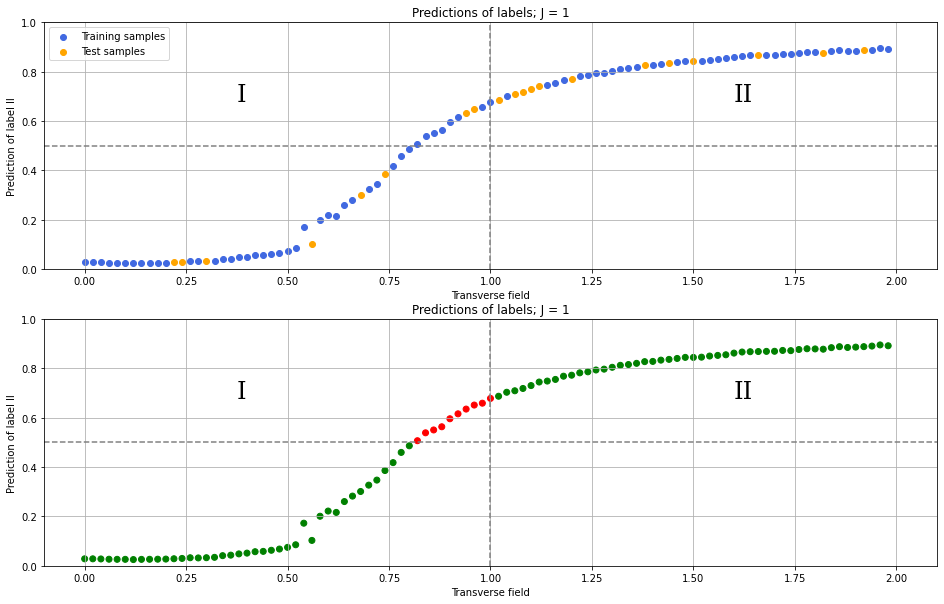

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(16,10))

ax[0].set_xlim(-0.1,2.1)
ax[0].set_ylim(0,1)
ax[0].grid(True)
ax[0].axhline(y=.5, color='gray', linestyle='--')
ax[0].axvline(x=1, color='gray', linestyle='--')
ax[0].text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
ax[0].text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
ax[0].set_xlabel('Transverse field')
ax[0].set_ylabel('Prediction of label II')
ax[0].set_title('Predictions of labels; J = 1')
ax[0].scatter(2*np.sort(train_index)/len(data), predictions_train, c = 'royalblue', label='Training samples')
ax[0].scatter(2*np.sort(test_index)/len(data), predictions_test, c = 'orange', label='Test samples')
ax[0].legend()

ax[1].set_xlim(-0.1,2.1)
ax[1].set_ylim(0,1)
ax[1].grid(True)
ax[1].axhline(y=.5, color='gray', linestyle='--')
ax[1].axvline(x=1, color='gray', linestyle='--')
ax[1].text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
ax[1].text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
ax[1].set_xlabel('Transverse field')
ax[1].set_ylabel('Prediction of label II')
ax[1].set_title('Predictions of labels; J = 1')
ax[1].scatter(2*np.sort(train_index)/len(data), predictions_train, c = colors_train)
ax[1].scatter(2*np.sort(test_index)/len(data), predictions_test, c = colors_test)

---
## Resources
* [Quantum Convolutional Neural Networks](https://arxiv.org/abs/1810.03787)
* [Machine Learning Phase Transitions with a Quantum Processor](https://arxiv.org/abs/1906.10155)

---
## Backup code

## Backup code 1: Shift-invariant Ansatz

<img src="./imgs/siansatz.svg" alt="ansatz" width="1000"/>

In [33]:
dev_vqe_backup = qml.device('default.qubit', wires=10)

def vqe_circuit_2(param, N = 8):
    '''
    Build the circuit to find the Groud-State of the 
    Ising-Chain Hamiltonian
    '''
    qml.RY(param[0], wires = 0)
    qml.RX(param[1], wires = 0)
    
    qml.RY(param[2], wires = N - 1)
    qml.RX(param[3], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RY(param[4], wires = spin)
        qml.RY(param[5], wires = spin+1)
        qml.RX(param[6], wires = spin)
        qml.RX(param[7], wires = spin+1)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
    
    qml.Barrier()
    
    qml.RY(param[8], wires = 0)
    qml.RX(param[9], wires = 0)
    
    qml.RY(param[10], wires = N - 1)
    qml.RX(param[11], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RY(param[12], wires = spin)
        qml.RY(param[13], wires = spin+1)
        qml.RX(param[14], wires = spin)
        qml.RX(param[15], wires = spin+1)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
     
    qml.RX(param[16], wires = 0)
    qml.RX(param[17], wires = N - 1)
    
    qml.RY(param[18], wires = 0)
    qml.RY(param[19], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RX(param[20], wires = spin)
        qml.RX(param[21], wires = spin+1)
        qml.RY(param[22], wires = spin)
        qml.RY(param[23], wires = spin+1)

def train_vqe_ising_shiftinvariant(step_size, l_steps, n_epochs, N, J, dev, circuit = False, plots = False, first_epochs = False):
    '''
    step_size = Step size of the optimizer
    epochs    = # epochs for each lambda (magnetic field)
    lams      = Array of intensities of magnetic field
    N         = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size = {0} (Step size of the optimizer)'.format(step_size))
    print('epochs    = {0} (# epochs for each lambda)'.format(n_epochs))
    print('N         = {0} (Number of spins of the system)'.format(N))
    
    lams = np.linspace(0,2*J,l_steps)
    
    vqe_e = []
    errs = np.zeros((n_epochs, len(lams)) )
    
    @qml.qnode(dev_vqe_backup)
    def cost_fn(param):
        vqe_circuit_2(param, N)
        # return <psi|H|psi>
        return qml.expval(H)
    
    thetas = np.array(np.random.randn(24), requires_grad = True) # Prepare initial state
    
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        
        H = qml_build_H(N, 0, 0)        
        drawer = qml.draw(cost_fn)
        print(drawer(thetas))
    
    thetas_arr = []
    ys = [] # Labels of the phase
    for i, l in enumerate(tqdm(lams)):
        opt = qml.AdamOptimizer(stepsize=step_size)
        H = qml_build_H(N, float(l), J)
        
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = np.min(qml.eigvals(H))
        
        epochs = first_epochs if i == 0 else n_epochs
        
        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            if i != 0:
                if epoch < n_epochs:
                    errs[epoch-1, i] = (prev_energy - GS_H)**2
            
        vqe_e.append(cost_fn(thetas))
        thetas_arr.append(thetas)
        ys.append(0) if l <= J else ys.append(1)
        
    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(10,10))

        true_e = []
        for l in lams:
            H = qml_build_H(N, float(l), J)
            true_e.append(np.min(qml.eigvals(H)) )
            
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()

        ax[1].plot(range(epochs), np.mean(errs, axis=1), '.', color='orange', ms = 7 )
        ax[1].plot(range(epochs), np.mean(errs, axis=1), color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        ax[2].legend()
        
        plt.tight_layout()
        plt.show()
        
         
        
    return vqe_e, errs, thetas_arr, ys   

***Parameters:***

step_size = 0.05 (Step size of the optimizer)
epochs    = 50 (# epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(-0.21)──RX(0.85)──╭C────────────────────||──RY(-0.46)──RX(1.66)──╭C──RX(-0.44)──RY(-0.24)
1: ──RY(0.19)───RX(0.29)──╰X─╭C─────────────────||──RY(0.83)───RX(0.85)──╰X─╭C──────────RX(-0.90)
2: ──RY(1.75)───RX(0.18)─────╰X─╭C──────────────||──RY(0.03)───RX(-0.42)────╰X─────────╭C────────
3: ──RY(0.19)───RX(0.29)────────╰X─╭C───────────||──RY(0.83)───RX(0.85)────────────────╰X────────
4: ──RY(1.75)───RX(0.18)───────────╰X─╭C────────||──RY(0.03)───RX(-0.42)─────────────────────────
5: ──RY(0.19)───RX(0.29)──────────────╰X─╭C─────||──RY(0.83)───RX(0.85)──────────────────────────
6: ──RY(1.75)───RX(0.18)─────────────────╰X─╭C──||──RY(0.03)───RX(-0.42)─────────────────────────
7: ──RY(0.43)───RX(-1.59)───────────────────╰X──||──RY(2.30)───RX(0.43)──────────────────────────

─────────────────────────────────────────────────────────────────┤ ╭<𝓗>
───RY(0.71)──────────────────────────────────────────────────────┤ ├<𝓗>
───RX(0.75)──RY(-1.32)───────────────────────────────────────────┤ ├<𝓗>

  0%|          | 0/100 [00:00<?, ?it/s]

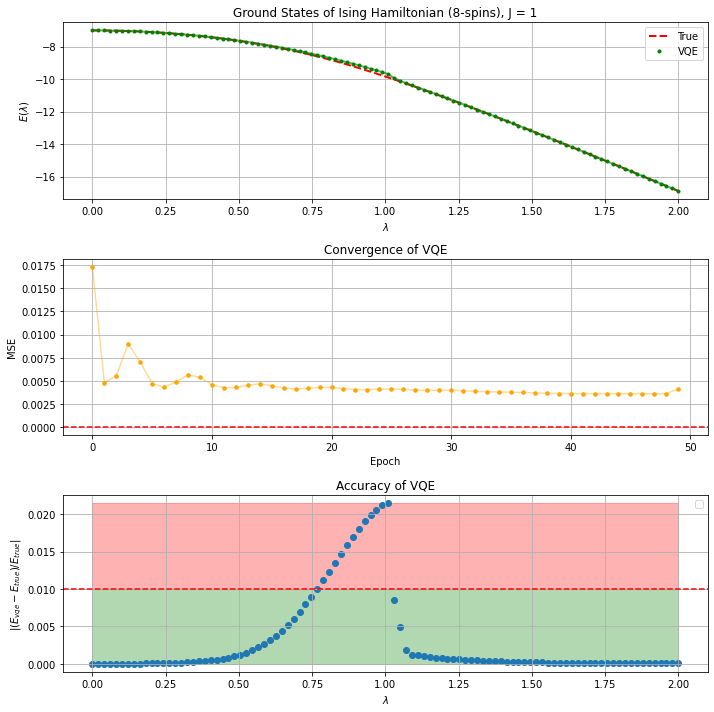

In [40]:
vqe_e, errs, thetas, ys = train_vqe_ising_shiftinvariant(step_size = 0.05, l_steps = 100, n_epochs = 50, N = 8, J = 1,
                                              dev = dev_vqe, circuit = True, plots = True, first_epochs = 500)

## Backup code 2: Weighted loss

In [41]:
def set_weights(strenght, sigma, data):
    W = []
    for k in range(len(data)):
        x = 2*k/(len(data))
        W.append( strenght*np.exp(-(1/sigma)*(x-1)**2) + 1)
        
    return W

In [42]:
def cross_entropy_weighted(labels, predictions, weights):
    '''
    f = - Σ [(Yi*log(Pi) + (1 - Yi)*log(1 - Pi) )]  for i in TrainingSet
    '''
    loss = 0
    for l, p, w in zip(labels, predictions, weights):
        c_entropy = ( l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l]) )
        loss = loss + w*c_entropy

    return -1 * loss

def cost_fn_weighted(params, X, Y, W):
    fn = lambda v: qcnn_8(v, params)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)

    predictions = vcircuit(X)
    #predictions = [qcnn_8(x, params) for x in X]
    loss = cross_entropy_weighted(Y, predictions, W)
    
    return loss

def compute_cost_batch_weighted(X, Y, W, params):
    '''
    Accuracy = (corretly predicted labels)/(total # of labels) * 100 ( %100) 
    '''
    data_len = len(X)
    
    if data_len == 0:
        return 0
    
    circuit = lambda v: cost_fn_weighted(v, X, Y, W)
    
    return circuit(params)

def compute_cost_weighted(X, Y, W, params, batch_size):
    n_batches = jnp.shape(X)[0]//batch_size
    
    cost = 0
    for batch in range(n_batches+1):
        start_batch = batch*(batch_size)
        end_batch = min( (batch+1)*(batch_size), jnp.shape(X)[0] )
        
        X_batch, Y_batch = jnp.array(X[start_batch:end_batch]), jnp.array(Y[start_batch:end_batch])
        W_batch = jnp.array(W[start_batch:end_batch])
        
        cost = cost + compute_cost_batch_weighted(X_batch, Y_batch, W_batch, params)
        
    return cost

# Training function
def qcnn_training_weighted(X_train, Y_train, W_train, X_test = [], Y_test = [], steps = 100, lr0 = 0.001, N = 8, plot = True, batch_size = 8):
    # Initialize parameters randomly
    params = jnp.array( np.random.randn(72) )
    
    loss_history = []
    accuracy_history = []
    #loss_history_test = []
    accuracy_history_test = []
    
    progress = tqdm(range(steps))
    
    n_batches      = jnp.shape(X_train)[0]//batch_size
    n_batches_test = jnp.shape(X_test)[0]//batch_size
    
    lr = lr0
    for epoch in progress:
        lr = lr0*(np.exp(-0.01*epoch))
        
        # Compute current loss and update parameters
        for batch in range(n_batches+1):
            params_batch = copy.copy(params)
            
            start_batch = (batch)*(batch_size)
            end_batch = min( (batch+1)*(batch_size), jnp.shape(X_train)[0] )
            
            if start_batch == end_batch:
                break
                
            X_batch, Y_batch = jnp.array(X_train[start_batch:end_batch]), jnp.array(Y_train[start_batch:end_batch])
            W_batch =jnp.array(W_train[start_batch:end_batch])
            
            circuit = lambda v: cost_fn_weighted(v, X_batch, Y_batch, W_batch)
            grad_circuit = jax.grad(circuit)
            params -= lr*grad_circuit(params)
        
        if epoch % 10 == 0:
            loss_history.append(compute_cost_weighted(X_train, Y_train, W_train, params, 16) )
            accuracy_history.append( compute_accuracy(X_train, Y_train, params, 16) )
            
            if len(X_test) > 0:
                accuracy_history_test.append(compute_accuracy(X_test, Y_test, params, 16) )
        
        # Set description to current loss
        progress.set_description('Cost: {0} | Accuracy: {1}'.format(np.round(loss_history[-1],3), accuracy_history[-1]) )
        
    print('Accuracy on Training Set: {0}'.format(compute_accuracy(X_train, Y_train, params, batch_size) ) )

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(loss_history))*10, np.asarray(loss_history), label = 'Training Loss')
       #if len(X_test) > 0:
            #plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(len(accuracy_history))*10, accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(len(accuracy_history))*10, accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return loss_history, accuracy_history, params

In [43]:
W = np.array(set_weights(5, 0.1, data))

Text(0.5, 1.0, 'Weights')

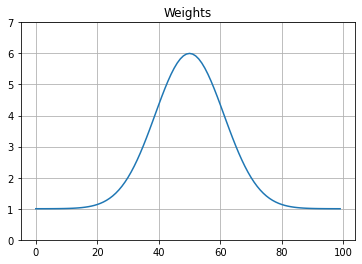

In [49]:
plt.plot(W)
plt.ylim(0,np.max(W)+1)
plt.grid(True)
plt.title('Weights')

In [50]:
W_train = W[train_index]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy on Training Set: 97.5


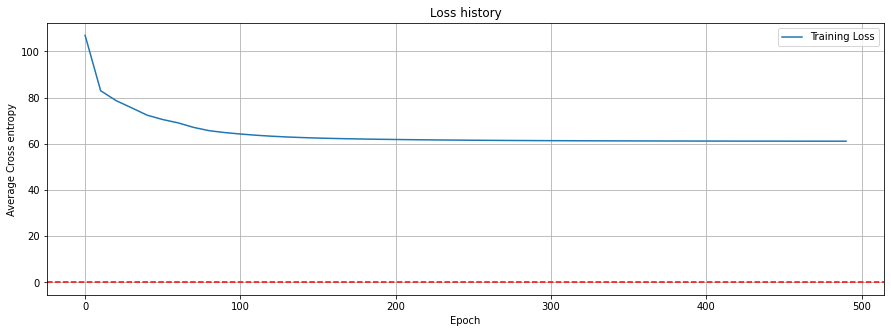

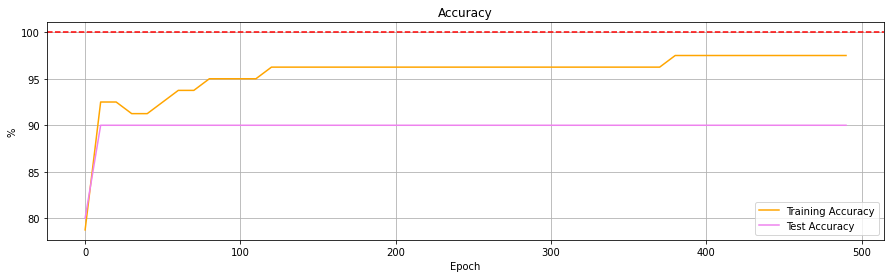

In [51]:
loss_history, accuracy_history, params = qcnn_training_weighted(X_train, Y_train, W_train, X_test, Y_test, 
                                                                steps = 500, lr0 = 5e-2, N = 8, plot = True, batch_size = 16)

In [52]:
predictions_train = []
predictions_test  = []

colors_train = []
colors_test  = []

for i in range(len(data)):
    prediction = qcnn_8(data[i][0],params)[1]
    
    # if data in training set
    if i in train_index:
        predictions_train.append(prediction)
        if np.round(prediction) == 0:
            if i <= len(data)/2:
                colors_train.append('green')
            else:
                colors_train.append('red')
        else:
            if i <= len(data)/2:
                colors_train.append('red')
            else:
                colors_train.append('green')
    else:
        predictions_test.append(prediction)
        if np.round(prediction) == 0:
            if i <= len(data)/2:
                colors_test.append('green')
            else:
                colors_test.append('red')
        else:
            if i <= len(data)/2:
                colors_test.append('red')
            else:
                colors_test.append('green')

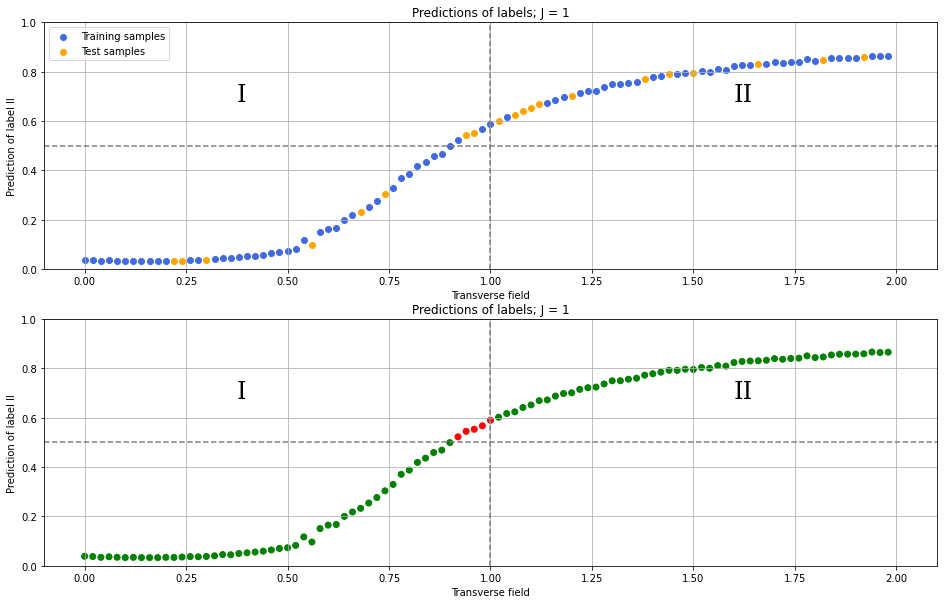

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(16,10))

ax[0].set_xlim(-0.1,2.1)
ax[0].set_ylim(0,1)
ax[0].grid(True)
ax[0].axhline(y=.5, color='gray', linestyle='--')
ax[0].axvline(x=1, color='gray', linestyle='--')
ax[0].text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
ax[0].text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
ax[0].set_xlabel('Transverse field')
ax[0].set_ylabel('Prediction of label II')
ax[0].set_title('Predictions of labels; J = 1')
ax[0].scatter(2*np.sort(train_index)/len(data), predictions_train, c = 'royalblue', label='Training samples')
ax[0].scatter(2*np.sort(test_index)/len(data), predictions_test, c = 'orange', label='Test samples')
ax[0].legend()

ax[1].set_xlim(-0.1,2.1)
ax[1].set_ylim(0,1)
ax[1].grid(True)
ax[1].axhline(y=.5, color='gray', linestyle='--')
ax[1].axvline(x=1, color='gray', linestyle='--')
ax[1].text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
ax[1].text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
ax[1].set_xlabel('Transverse field')
ax[1].set_ylabel('Prediction of label II')
ax[1].set_title('Predictions of labels; J = 1')
ax[1].scatter(2*np.sort(train_index)/len(data), predictions_train, c = colors_train)
ax[1].scatter(2*np.sort(test_index)/len(data), predictions_test, c = colors_test)

In [54]:
joblib.dump(params, './qcnn8_params.job')

['./qcnn8_params.job']